# **DCGAN hands generator**

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import urllib.request
from IPython import display

## 1. Dataset

### 1.1 Load dataset

In [2]:
DATASET_DOWNLOAD_URL = "https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/signs-training.zip"
ZIP_DIR = "signs-training.zip"
DATASET_DIR = '/dataset'

urllib.request.urlretrieve(DATASET_DOWNLOAD_URL, ZIP_DIR)

with zipfile.ZipFile(ZIP_DIR, 'r') as unpack:
    unpack.extractall(DATASET_DIR)

### 1.2 Preprocess the dataset

In [3]:
BATCH_SIZE = 32

def load_and_preprocess(file):
    img = tf.io.decode_png(tf.io.read_file(file))
    img = tf.dtypes.cast(img, tf.float32)
    img = img / 255.0
    return img


dataset_filenames = tf.data.Dataset.list_files("/dataset/signs-training/*.png")

dataset = dataset_filenames.map(load_and_preprocess)

print(f'Number of records: {dataset.cardinality().numpy()}')
print(f'Image dimensions: {next(iter(dataset)).shape}')

dataset = dataset.batch(BATCH_SIZE)

Number of records: 27455
Image dimensions: (28, 28, 1)


### 1.3 Preview the dataset

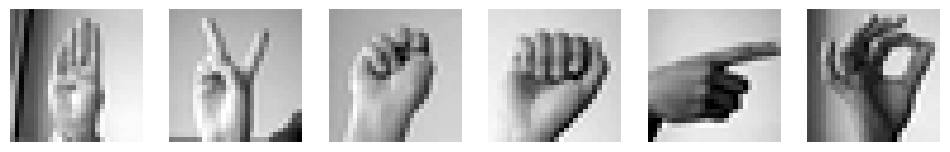

In [4]:
for images in dataset.take(1):
    
    fig, axs = plt.subplots(1,6, figsize=(12,2))

    for i in range(6):
        axs[i].axis('off')
        axs[i].imshow(images[i], cmap='gray')

## 2. Model

### 2.1 Generator

In [15]:
def get_generator(input_shape):
    input = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(7*7*128)(input)
    x = tf.keras.layers.Reshape([7, 7, 128])(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding="SAME", activation="selu")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    y = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=5, strides=2, padding="SAME", activation="tanh")(x)
    
    model = tf.keras.Model(inputs=input, outputs=y, name="Generator")
    return model

### 2.2 Discriminator

In [16]:
def get_discriminator(input_shape=[28, 28, 1]):
    input = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME", activation=tf.keras.layers.LeakyReLU(0.2))(input)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME", activation=tf.keras.layers.LeakyReLU(0.2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Flatten()(x)
    y = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=input, outputs=y, name="Discriminator")
    return model

### 2.3 DCGAN

In [17]:
def get_DCGAN(generator, discriminator):

    discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
    discriminator.trainable = False

    model = tf.keras.models.Sequential([generator, discriminator], name="DCGAN")
    model.compile(loss="binary_crossentropy", optimizer="rmsprop")
    return model


random_normal_dimensions = 32

generator = get_generator(random_normal_dimensions)
discriminator = get_discriminator()

generator.summary()
discriminator.summary()

DCGAN = get_DCGAN(generator, discriminator)
DCGAN.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_2 (Dense)             (None, 6272)              206976    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 64)       204864    
 ranspose)                                                       
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)       25

## 3. Train

### 3.1 Training function

In [8]:
def train_gan(gan, dataset, random_normal_dimensions, epochs=50):
    generator, discriminator = gan.layers

    # print(generator, discriminator)

    #todo use normal training loop, it looks too complicated

    for epoch in range(epochs):
        print(f"Epoch {epoch}")

        for real_images in dataset:
            real_batch_size = real_images.shape[0]

            noise = tf.random.normal(shape=[real_batch_size, random_normal_dimensions])
            
            fake_images = generator(noise)
            
            mixed_images = tf.concat([fake_images, real_images], axis=0)
            
            discriminator_labels = tf.constant([[0.]] * real_batch_size + [[1.]] * real_batch_size)
            
            discriminator.trainable = True
            
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            
            noise = tf.random.normal(shape=[real_batch_size, random_normal_dimensions])
            
            generator_labels = tf.constant([[1.]] * real_batch_size)

            discriminator.trainable = False

            gan.train_on_batch(noise, generator_labels)

        plot_results(fake_images, 16)                     
        plt.show()
    return fake_images

### 3.2 Run the training

In [13]:
def plot_results(images, n_cols=None):
    # display.clear_output(wait=False)  
    
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Epoch 0


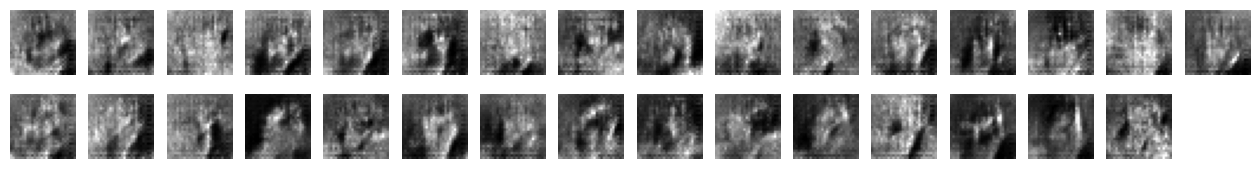

Epoch 1


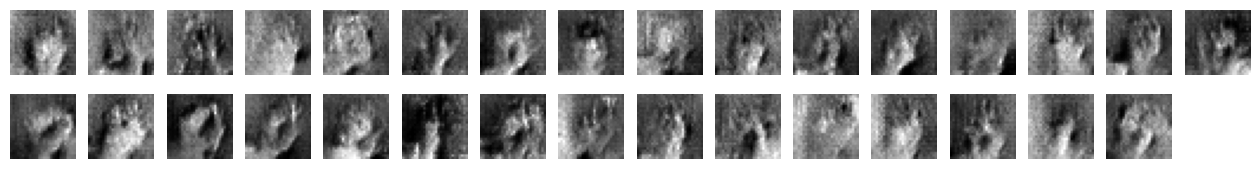

Epoch 2


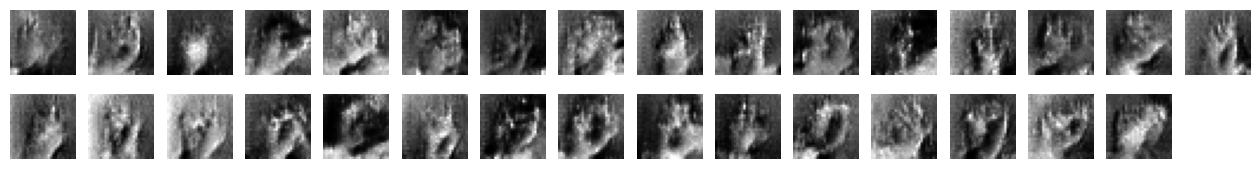

Epoch 3


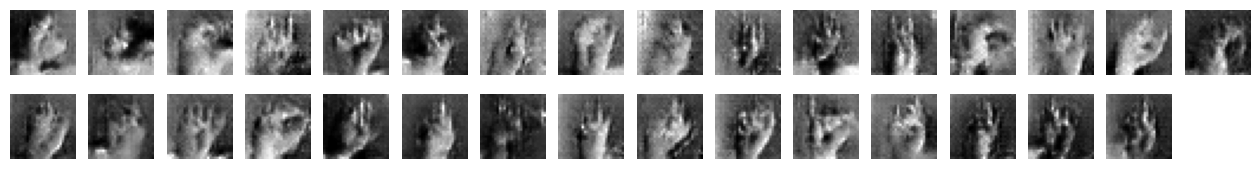

Epoch 4


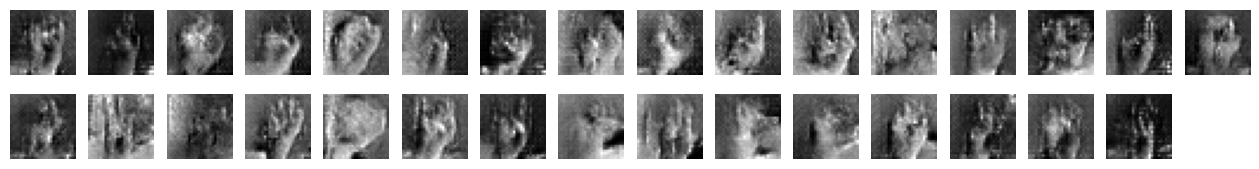

Epoch 5


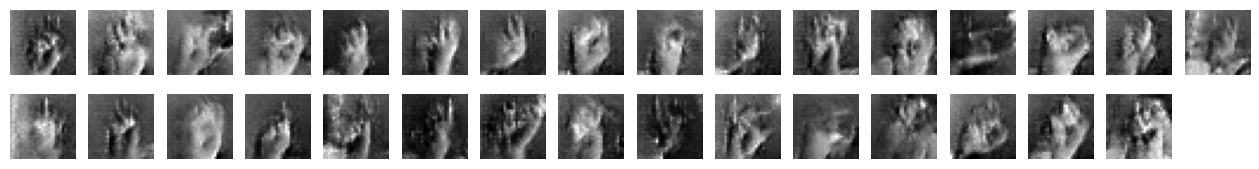

Epoch 6


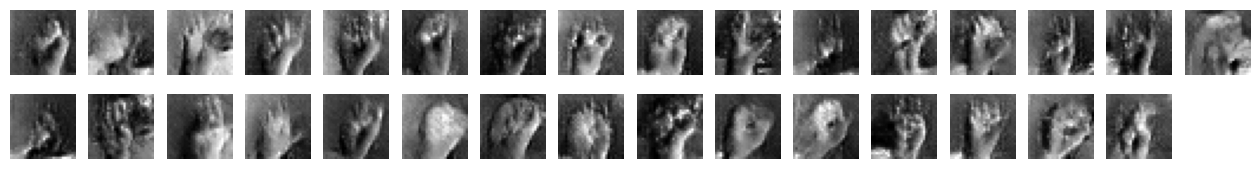

Epoch 7


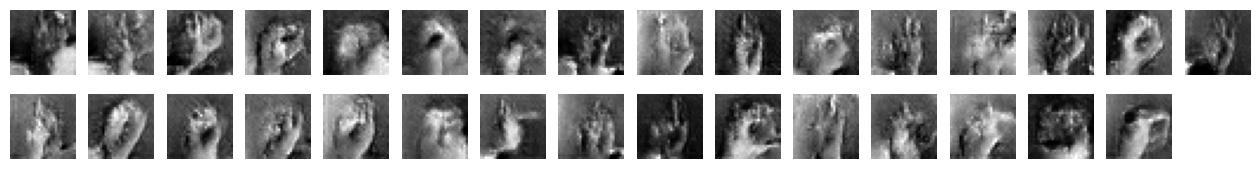

Epoch 8


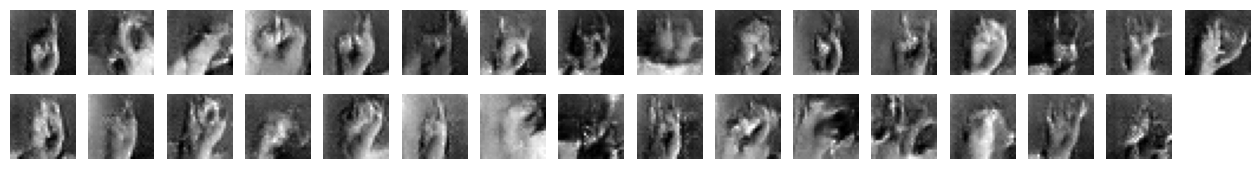

Epoch 9


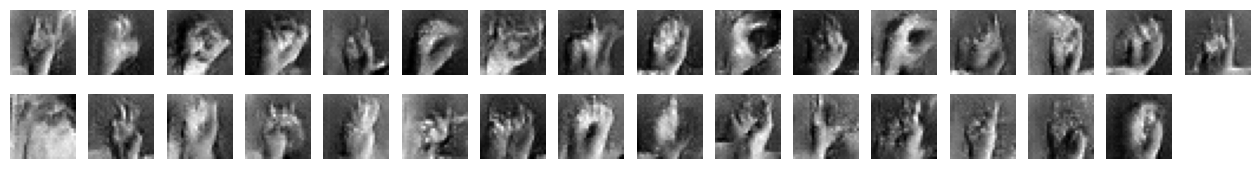

In [18]:
images = train_gan(DCGAN, dataset, random_normal_dimensions, 10)

## 4. Evaluate

### 4.1 Model loss history

### 4.2 Generate some results

## 5. Save the model